In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torch.distributions as dist
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal

import pandas as pd
from IPython.display import Image
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.acquisition.analytic import UpperConfidenceBound
import warnings
import gymnasium as gym
import umap
import importlib
import optuna

In [2]:
import env.make
import env.eval
import env.dataset
import utils.utils as utils
importlib.reload(env.make)
importlib.reload(env.eval)
importlib.reload(env.dataset)
importlib.reload(utils);

In [3]:
%config InlineBackend.figure_format='retina'

In [4]:
DEVICE = utils.find_device(force_cpu=False)

Using device cuda


In [5]:
FIG_FOLDER, BACKUP_FOLDER = utils.make_folders()

Figures folder: ./figures
Backup folder: ./backup


# Create env and fix horizon

In [6]:
ENV = env.make.mujoco_cartpole()
TIME_HORIZON = 20

# Creating a dataset

In [7]:
train_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=1234)
test_dataset = env.dataset.make(env=ENV, time_horizon=TIME_HORIZON, device=DEVICE, seed=12345)

Sampling trajectories and evaluating them...
n=2000; avg = 0.303 +/- 0.166; range  = 0.150, 1.000
Sampling trajectories and evaluating them...
n=2000; avg = 0.296 +/- 0.160; range  = 0.150, 1.000


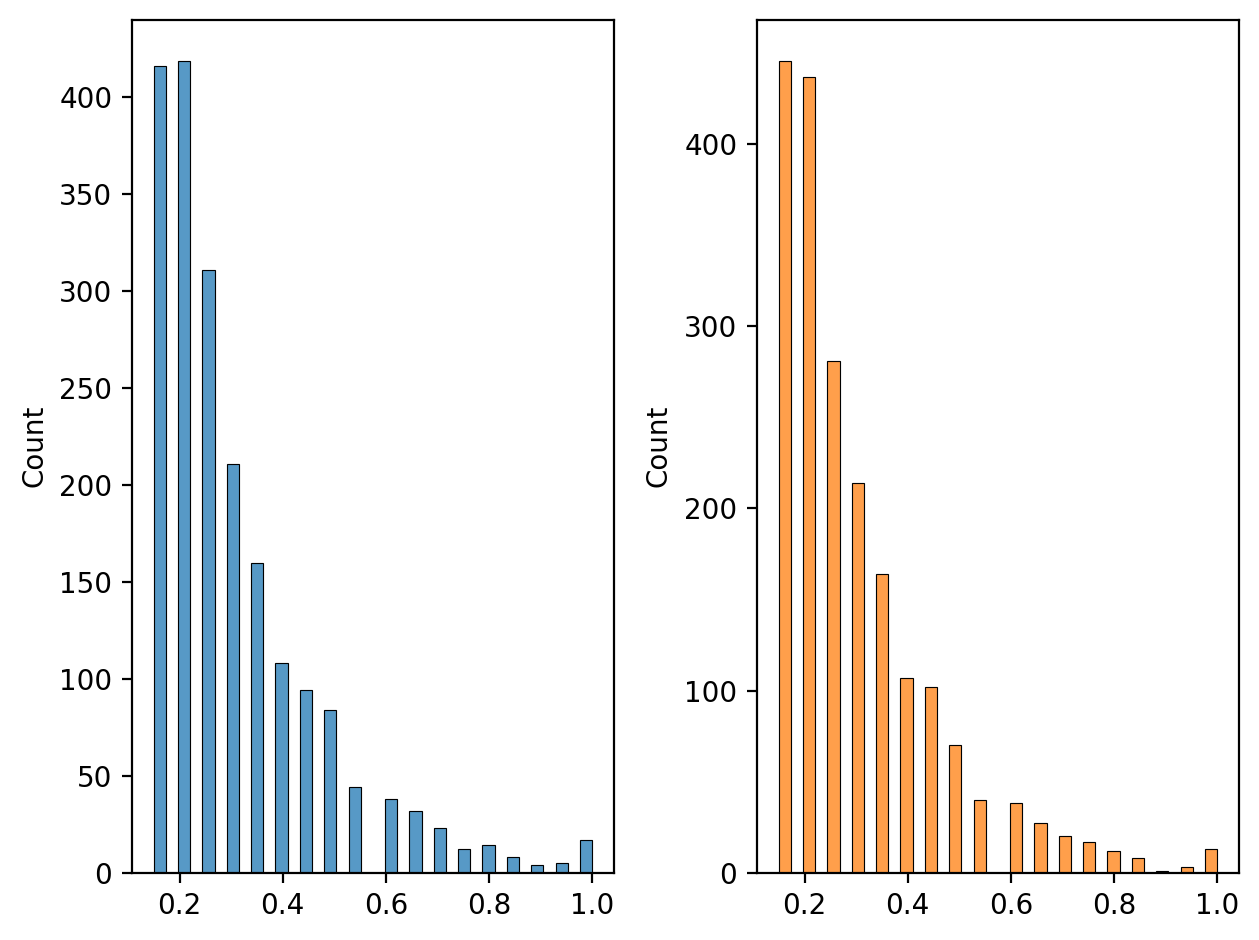

In [8]:
fig, axes = plt.subplots(ncols=2)
sns.histplot(ax=axes[0], x=train_dataset.y.cpu().numpy())
sns.histplot(ax=axes[1], x=test_dataset.y.cpu().numpy(), color="C1")
plt.tight_layout();

# AE

## Defining the AE model

In [15]:
class AE(nn.Module):
    # https://github.com/chrisvdweth/ml-toolkit/blob/master/pytorch/models/text/autoencoder/textrnnvae.py
    def __init__(self, time_horizon, z_dim, device, hidden_dim, num_layers, bidirectional, dropout):
        super().__init__()
        
        # References
        self.num_layers, self.hidden_dim, self.device = num_layers, hidden_dim, device
        self.time_horizon, self.num_directions = time_horizon, 2 if bidirectional else 1

        # For encoder
        self.enc = nn.GRU(
            input_size=1, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True)
        
        self.enc_linear = nn.Linear(hidden_dim*num_layers*self.num_directions, z_dim)
        # self.mu = nn.Linear(hidden_dim*num_layers, z_dim)
        # self.logvar = nn.Linear(hidden_dim*num_layers, z_dim)

        # For decoder 
        self.z_to_hidden = nn.Linear(z_dim, hidden_dim*num_layers*self.num_directions)
        self.out_to_seq = nn.Linear(hidden_dim*self.num_directions, 1)
        
        self.dec = nn.GRU(
            input_size=1, 
            hidden_size=hidden_dim, 
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True)
        
    def encode(self, x):
        x = x.unsqueeze(-1)
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers*self.num_directions, batch_size, self.hidden_dim).to(self.device) 
        out, h = self.enc(x, h0)
        # (num_layers*num_directions, batch_size, hidden_dim)  ==>
        # (batch_size, num_directions*num_layers, hidden_dim)  ==>
        # (batch_size, num_directions*num_layers*hidden_dim)
        h = h.transpose(0, 1).contiguous().view(batch_size, -1)
        
        z = self.enc_linear(h)
        # mu = self.mu(h)
        # logvar = self.logvar(h)
        return z # mu , logvar

    #def reparameterize(self, mu, logvar):
    #    std = torch.exp(0.5*logvar)
    #    eps = torch.randn_like(std)
    #    return mu + eps*std

    def decode(self, z):
        batch_size = z.shape[0]
        h = self.z_to_hidden(z)

        # (batch_size, num_directions*num_layers*hidden_dim)    ==>
        # (batch_size, num_directions*num_layers, hidden_dim) ==>
        # (num_layers * num_directions, batch_size, hidden_dim) ==>
        h = h.view(batch_size, self.num_layers*self.num_directions, self.hidden_dim).transpose(0, 1).contiguous()
        input = torch.ones(batch_size, 1, 1).to(self.device)
        x = torch.empty((batch_size, self.time_horizon)).to(self.device)
        for step in range(self.time_horizon):
            out, h = self.dec(input, h)
            seq = self.out_to_seq(out.squeeze())
            xi = torch.sigmoid(seq.squeeze())
            x[:, step] = xi
        return torch.flip(x, [-1])

    def forward(self, x):
        # mu, logvar = self.encode(x)
        # z = self.reparameterize(mu, logvar)
        z = self.encode(x)
        return self.decode(z) # self.decode(z), mu, logvar

## Define z dimensionality

In [16]:
Z_DIM = 2

## Training AE

In [17]:
def eval_reconstruction(model, data_loader, verbose=True):
    delta = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(data_loader):
            recon_x = model(x)
            delta += torch.abs(x - recon_x).sum()

    n = len(data_loader.dataset)
    delta /= (n*model.time_horizon)
    if verbose:
        print(f"Avg reconstruction error: {delta.item():.4f}")
    return delta.item()

### Random level for reconstruction

In [18]:
x = train_dataset.x
recon_x = torch.rand_like(x)
delta = torch.abs(x - recon_x)
print(f"Avg reconstruction error: {delta.mean().item():.4f} +/- {delta.std().item():.4f}")

Avg reconstruction error: 0.3325 +/- 0.2359


### Initial level of reconstruction error

In [21]:
seed = 1234
torch.manual_seed(seed)

ae = AE(time_horizon=TIME_HORIZON, 
        z_dim=Z_DIM, 
        hidden_dim=500, 
        num_layers=2,
        dropout=0.1,
        bidirectional=True,
        device=DEVICE).to(DEVICE)

train_loader = DataLoader(dataset=train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

eval_reconstruction(ae, train_loader)
eval_reconstruction(ae, test_loader)

Avg reconstruction error: 0.2504
Avg reconstruction error: 0.2504


0.25036564469337463

### Training loop

In [38]:
def train_model(
        train_loader,
        test_loader,
        bidirectional=False,
        batch_size=2000,
        num_layers=2,
        hidden_dim=500,
        dropout=0,
        learning_rate=0.001, 
        seed=1234,
        n_epoch=5000):
    
    torch.manual_seed(seed)
    
    ae = AE(time_horizon=TIME_HORIZON, 
            hidden_dim=hidden_dim, 
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
            z_dim=Z_DIM, 
            device=DEVICE).to(DEVICE)
    
    optimizer = optim.Adam(list(ae.parameters()), lr=learning_rate) # + list(reg.parameters()), lr=lr)
    
    # hist_loss = []
    
    with tqdm(total=n_epoch, leave=True) as pbar:
        
        for epoch in range(n_epoch):
            
            epoch_loss = 0 
                        
            for batch_idx, (x, y) in enumerate(train_loader):
    
                optimizer.zero_grad()
                recon_x = ae(x)
                loss = nn.MSELoss(reduction="mean")(target=x, input=recon_x)
                
                loss.backward()
                optimizer.step()
    
                epoch_loss += loss.item()
            # hist_loss.append(epoch_loss/len(train_loader))
    
            pbar.update()
            pbar.set_postfix(loss=f"{epoch_loss/len(train_loader):.5f}")

        mean_rec_err_TRAIN = eval_reconstruction(ae, train_loader, verbose=False)
        mean_rec_err = eval_reconstruction(ae, test_loader, verbose=False)
        pbar.set_postfix({"Avg. rec. error TRAIN": mean_rec_err_TRAIN, "Avg. rec. error TEST": mean_rec_err})
    return mean_rec_err
    

In [39]:
batch_size = len(train_dataset.y)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

def objective(trial):

    bidirectional = trial.suggest_categorical("bidirectional", [False, True])
    hidden_dim = trial.suggest_int("hidden_dim", 2, 500)
    num_layers = trial.suggest_int("num_layers", 1, 5)
    # learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.001)
    dropout = trial.suggest_float("dropout", 0.0, 0.2)
    # eval_reconstruction(ae, train_loader)
    mean_rec_err = train_model(
        train_loader=train_loader,
        test_loader=test_loader,
        hidden_dim=hidden_dim, 
        num_layers=num_layers, 
        learning_rate=0.0005,
        bidirectional=bidirectional,
        dropout=dropout,
        batch_size=batch_size,
        n_epoch=5000,
    )

    # trial.set_user_attr("accuracy", accuracy)
    return mean_rec_err

# os.remove('optuna_tuning.db')
study = optuna.create_study(direction="minimize", 
                            study_name='Mujoco-CartPole-RNN', 
                            storage='sqlite:///optuna_tuning.db')
study.optimize(objective, n_trials=250, show_progress_bar=False, 
               catch=(Exception, ))

[I 2023-03-31 18:06:35,337] A new study created in RDB with name: Mujoco-CartPole-RNN


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 18:15:47,178] Trial 0 finished with value: 0.20694638788700104 and parameters: {'bidirectional': True, 'hidden_dim': 42, 'num_layers': 5, 'dropout': 0.0021218951447662393}. Best is trial 0 with value: 0.20694638788700104.


0.20694638788700104
0.2026975005865097


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 18:53:04,172] Trial 1 finished with value: 0.206839919090271 and parameters: {'bidirectional': True, 'hidden_dim': 303, 'num_layers': 5, 'dropout': 0.010620202663362744}. Best is trial 1 with value: 0.206839919090271.


0.206839919090271
0.20513617992401123


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 19:01:46,960] Trial 2 finished with value: 0.2847994863986969 and parameters: {'bidirectional': True, 'hidden_dim': 360, 'num_layers': 2, 'dropout': 0.17931971686360146}. Best is trial 1 with value: 0.206839919090271.


0.2847994863986969
0.08639674633741379


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 19:08:59,393] Trial 3 finished with value: 0.1994388848543167 and parameters: {'bidirectional': True, 'hidden_dim': 205, 'num_layers': 3, 'dropout': 0.14690391656740207}. Best is trial 3 with value: 0.1994388848543167.


0.1994388848543167
0.19471830129623413


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 19:14:17,580] Trial 4 finished with value: 0.2329009771347046 and parameters: {'bidirectional': False, 'hidden_dim': 204, 'num_layers': 4, 'dropout': 0.07965220878702164}. Best is trial 3 with value: 0.1994388848543167.


0.2329009771347046
0.23201191425323486


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 19:21:01,054] Trial 5 finished with value: 0.2517096698284149 and parameters: {'bidirectional': True, 'hidden_dim': 285, 'num_layers': 2, 'dropout': 0.10105385278936158}. Best is trial 3 with value: 0.1994388848543167.


0.2517096698284149
0.1317926049232483


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 19:29:34,942] Trial 6 finished with value: 0.22036400437355042 and parameters: {'bidirectional': False, 'hidden_dim': 125, 'num_layers': 5, 'dropout': 0.09756076831104643}. Best is trial 3 with value: 0.1994388848543167.


0.22036400437355042
0.2185806781053543


/home/aurelien/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12330830784629264 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 19:34:02,159] Trial 7 finished with value: 0.25232166051864624 and parameters: {'bidirectional': True, 'hidden_dim': 406, 'num_layers': 1, 'dropout': 0.12330830784629264}. Best is trial 3 with value: 0.1994388848543167.


0.25232166051864624
0.1380578875541687


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 20:02:30,167] Trial 8 finished with value: 0.20322760939598083 and parameters: {'bidirectional': True, 'hidden_dim': 468, 'num_layers': 4, 'dropout': 0.18478572120336711}. Best is trial 3 with value: 0.1994388848543167.


0.20322760939598083
0.2007131725549698


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 20:10:39,570] Trial 9 finished with value: 0.18944567441940308 and parameters: {'bidirectional': True, 'hidden_dim': 69, 'num_layers': 5, 'dropout': 0.16672003315773737}. Best is trial 9 with value: 0.18944567441940308.


0.18944567441940308
0.18851329386234283


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 20:13:35,663] Trial 10 finished with value: 0.21278397738933563 and parameters: {'bidirectional': False, 'hidden_dim': 23, 'num_layers': 4, 'dropout': 0.19513610634315487}. Best is trial 9 with value: 0.18944567441940308.


0.21278397738933563
0.21226318180561066


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 20:43:47,186] Trial 11 finished with value: 0.19840353727340698 and parameters: {'bidirectional': True, 'hidden_dim': 162, 'num_layers': 3, 'dropout': 0.15893468006386915}. Best is trial 9 with value: 0.18944567441940308.


0.19840353727340698
0.19574104249477386


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 20:52:08,790] Trial 12 finished with value: 0.20553608238697052 and parameters: {'bidirectional': True, 'hidden_dim': 107, 'num_layers': 3, 'dropout': 0.16262143980230812}. Best is trial 9 with value: 0.18944567441940308.


0.20553608238697052
0.20269213616847992


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 20:58:28,902] Trial 13 finished with value: 0.2026042938232422 and parameters: {'bidirectional': True, 'hidden_dim': 120, 'num_layers': 2, 'dropout': 0.14663986159823597}. Best is trial 9 with value: 0.18944567441940308.


0.2026042938232422
0.1929517388343811


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 21:34:08,173] Trial 14 finished with value: 0.22082877159118652 and parameters: {'bidirectional': True, 'hidden_dim': 186, 'num_layers': 3, 'dropout': 0.19877803005808983}. Best is trial 9 with value: 0.18944567441940308.


0.22082877159118652
0.21878840029239655


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 21:38:00,613] Trial 15 finished with value: 0.20973104238510132 and parameters: {'bidirectional': False, 'hidden_dim': 76, 'num_layers': 4, 'dropout': 0.16459903509512464}. Best is trial 9 with value: 0.18944567441940308.


0.20973104238510132
0.20787714421749115


/home/aurelien/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13675789931298168 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 21:43:22,771] Trial 16 finished with value: 0.2345249503850937 and parameters: {'bidirectional': True, 'hidden_dim': 153, 'num_layers': 1, 'dropout': 0.13675789931298168}. Best is trial 9 with value: 0.18944567441940308.


0.2345249503850937
0.20662279427051544


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 21:46:10,494] Trial 17 finished with value: 0.21784549951553345 and parameters: {'bidirectional': True, 'hidden_dim': 6, 'num_layers': 2, 'dropout': 0.17275331507541578}. Best is trial 9 with value: 0.18944567441940308.


0.21784549951553345
0.21711716055870056


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 21:52:22,554] Trial 18 finished with value: 0.20821961760520935 and parameters: {'bidirectional': False, 'hidden_dim': 251, 'num_layers': 4, 'dropout': 0.15975558228717737}. Best is trial 9 with value: 0.18944567441940308.


0.20821961760520935
0.20692822337150574


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 21:57:23,189] Trial 19 finished with value: 0.199762225151062 and parameters: {'bidirectional': True, 'hidden_dim': 72, 'num_layers': 3, 'dropout': 0.1208018202060151}. Best is trial 9 with value: 0.18944567441940308.


0.199762225151062
0.1972418576478958


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 22:11:22,976] Trial 20 finished with value: 0.22274257242679596 and parameters: {'bidirectional': True, 'hidden_dim': 252, 'num_layers': 5, 'dropout': 0.1980310185994672}. Best is trial 9 with value: 0.18944567441940308.


0.22274257242679596
0.22254332900047302


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 22:18:22,149] Trial 21 finished with value: 0.2593991458415985 and parameters: {'bidirectional': True, 'hidden_dim': 193, 'num_layers': 3, 'dropout': 0.15364388019316136}. Best is trial 9 with value: 0.18944567441940308.


0.2593991458415985
0.12431997060775757


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 22:49:09,605] Trial 22 finished with value: 0.20086301863193512 and parameters: {'bidirectional': True, 'hidden_dim': 165, 'num_layers': 3, 'dropout': 0.14018446647108626}. Best is trial 9 with value: 0.18944567441940308.


0.20086301863193512
0.1977430284023285


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 22:57:24,978] Trial 23 finished with value: 0.2725118100643158 and parameters: {'bidirectional': True, 'hidden_dim': 230, 'num_layers': 3, 'dropout': 0.17548579621697216}. Best is trial 9 with value: 0.18944567441940308.


0.2725118100643158
0.10972780734300613


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 23:01:17,503] Trial 24 finished with value: 0.21983051300048828 and parameters: {'bidirectional': True, 'hidden_dim': 78, 'num_layers': 2, 'dropout': 0.15078122390908663}. Best is trial 9 with value: 0.18944567441940308.


0.21983051300048828
0.21523800492286682


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 23:17:25,717] Trial 25 finished with value: 0.21591004729270935 and parameters: {'bidirectional': True, 'hidden_dim': 314, 'num_layers': 4, 'dropout': 0.1756207342897608}. Best is trial 9 with value: 0.18944567441940308.


0.21591004729270935
0.21343153715133667


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 23:24:43,745] Trial 26 finished with value: 0.2315017580986023 and parameters: {'bidirectional': False, 'hidden_dim': 142, 'num_layers': 3, 'dropout': 0.13267875623929926}. Best is trial 9 with value: 0.18944567441940308.


0.2315017580986023
0.23105524480342865


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 23:34:24,294] Trial 27 finished with value: 0.2169950157403946 and parameters: {'bidirectional': True, 'hidden_dim': 224, 'num_layers': 4, 'dropout': 0.15963244438084992}. Best is trial 9 with value: 0.18944567441940308.


0.2169950157403946
0.21589910984039307


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 23:39:20,531] Trial 28 finished with value: 0.22290946543216705 and parameters: {'bidirectional': True, 'hidden_dim': 103, 'num_layers': 2, 'dropout': 0.14660633791379457}. Best is trial 9 with value: 0.18944567441940308.


0.22290946543216705
0.21762025356292725


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 23:44:18,422] Trial 29 finished with value: 0.18759989738464355 and parameters: {'bidirectional': True, 'hidden_dim': 52, 'num_layers': 5, 'dropout': 0.1862105058295892}. Best is trial 29 with value: 0.18759989738464355.


0.18759989738464355
0.18515409529209137


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 23:49:18,326] Trial 30 finished with value: 0.19371770322322845 and parameters: {'bidirectional': True, 'hidden_dim': 43, 'num_layers': 5, 'dropout': 0.1861790906139007}. Best is trial 29 with value: 0.18759989738464355.


0.19371770322322845
0.19229952991008759


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 23:54:29,323] Trial 31 finished with value: 0.2034926563501358 and parameters: {'bidirectional': True, 'hidden_dim': 48, 'num_layers': 5, 'dropout': 0.18811400729946093}. Best is trial 29 with value: 0.18759989738464355.


0.2034926563501358
0.20195229351520538


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-03-31 23:58:19,181] Trial 32 finished with value: 0.2032211720943451 and parameters: {'bidirectional': True, 'hidden_dim': 30, 'num_layers': 5, 'dropout': 0.184373346254432}. Best is trial 29 with value: 0.18759989738464355.


0.2032211720943451
0.20306037366390228


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 00:03:29,742] Trial 33 finished with value: 0.18738412857055664 and parameters: {'bidirectional': True, 'hidden_dim': 54, 'num_layers': 5, 'dropout': 0.17045460685180824}. Best is trial 33 with value: 0.18738412857055664.


0.18738412857055664
0.18464826047420502


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 00:08:31,780] Trial 34 finished with value: 0.18762284517288208 and parameters: {'bidirectional': True, 'hidden_dim': 45, 'num_layers': 5, 'dropout': 0.1724541315872349}. Best is trial 33 with value: 0.18738412857055664.


0.18762284517288208
0.1851852685213089


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 00:13:54,231] Trial 35 finished with value: 0.21858273446559906 and parameters: {'bidirectional': True, 'hidden_dim': 57, 'num_layers': 5, 'dropout': 0.1701869720616934}. Best is trial 33 with value: 0.18738412857055664.


0.21858273446559906
0.2165813148021698


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 00:17:21,964] Trial 36 finished with value: 0.20403669774532318 and parameters: {'bidirectional': True, 'hidden_dim': 12, 'num_layers': 5, 'dropout': 0.1717592235786136}. Best is trial 33 with value: 0.18738412857055664.


0.20403669774532318
0.20273935794830322


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 00:22:48,325] Trial 37 finished with value: 0.21235600113868713 and parameters: {'bidirectional': False, 'hidden_dim': 93, 'num_layers': 5, 'dropout': 0.18388546165050867}. Best is trial 33 with value: 0.18738412857055664.


0.21235600113868713
0.21012118458747864


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 00:28:00,293] Trial 38 finished with value: 0.21787279844284058 and parameters: {'bidirectional': True, 'hidden_dim': 54, 'num_layers': 5, 'dropout': 0.16857648101069408}. Best is trial 33 with value: 0.18738412857055664.


0.21787279844284058
0.2170555144548416


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 00:49:04,612] Trial 39 finished with value: 0.2327076643705368 and parameters: {'bidirectional': True, 'hidden_dim': 134, 'num_layers': 5, 'dropout': 0.19169475253899623}. Best is trial 33 with value: 0.18738412857055664.


0.2327076643705368
0.15428608655929565


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 00:56:41,652] Trial 40 finished with value: 0.2124800980091095 and parameters: {'bidirectional': True, 'hidden_dim': 89, 'num_layers': 4, 'dropout': 0.17789628437223545}. Best is trial 33 with value: 0.18738412857055664.


0.2124800980091095
0.21052755415439606


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 01:01:18,113] Trial 41 finished with value: 0.19527499377727509 and parameters: {'bidirectional': True, 'hidden_dim': 35, 'num_layers': 5, 'dropout': 0.18749530378887333}. Best is trial 33 with value: 0.18738412857055664.


0.19527499377727509
0.19340968132019043


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 01:06:02,046] Trial 42 finished with value: 0.19154489040374756 and parameters: {'bidirectional': True, 'hidden_dim': 39, 'num_layers': 5, 'dropout': 0.19930998911042053}. Best is trial 33 with value: 0.18738412857055664.


0.19154489040374756
0.18904395401477814


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 01:09:29,583] Trial 43 finished with value: 0.20989714562892914 and parameters: {'bidirectional': True, 'hidden_dim': 8, 'num_layers': 5, 'dropout': 0.1985021577089627}. Best is trial 33 with value: 0.18738412857055664.


0.20989714562892914
0.20923422276973724


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 01:14:59,540] Trial 44 finished with value: 0.18191590905189514 and parameters: {'bidirectional': True, 'hidden_dim': 63, 'num_layers': 5, 'dropout': 0.18071479202676954}. Best is trial 44 with value: 0.18191590905189514.


0.18191590905189514
0.17975032329559326


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 01:26:05,038] Trial 45 finished with value: 0.19780908524990082 and parameters: {'bidirectional': True, 'hidden_dim': 113, 'num_layers': 4, 'dropout': 0.1797919007169564}. Best is trial 44 with value: 0.18191590905189514.


0.19780908524990082
0.194152370095253


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 01:39:22,956] Trial 46 finished with value: 0.21760165691375732 and parameters: {'bidirectional': False, 'hidden_dim': 395, 'num_layers': 5, 'dropout': 0.1640095595766285}. Best is trial 44 with value: 0.18191590905189514.


0.21760165691375732
0.2158776819705963


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 01:45:33,407] Trial 47 finished with value: 0.2157149612903595 and parameters: {'bidirectional': True, 'hidden_dim': 66, 'num_layers': 4, 'dropout': 0.1565187506301502}. Best is trial 44 with value: 0.18191590905189514.


0.2157149612903595
0.21401309967041016


  0%|          | 0/5000 [00:00<?, ?it/s]

[W 2023-04-01 01:45:34,232] Trial 48 failed with parameters: {'bidirectional': True, 'hidden_dim': 466, 'num_layers': 5, 'dropout': 0.16736738066252643} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 358.00 MiB (GPU 0; 23.69 GiB total capacity; 10.30 GiB already allocated; 222.06 MiB free; 10.65 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF').
Traceback (most recent call last):
  File "/home/aurelien/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2749631/326334075.py", line 13, in objective
    mean_rec_err = train_model(
  File "/tmp/ipykernel_2749631/3009605244.py", line 36, in train_model
    recon_x = ae(x)
  File "/home/aurelien/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", l

  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 01:48:58,758] Trial 49 finished with value: 0.2242237776517868 and parameters: {'bidirectional': True, 'hidden_dim': 2, 'num_layers': 5, 'dropout': 0.1665655590222331}. Best is trial 44 with value: 0.18191590905189514.


0.2242237776517868
0.22326794266700745


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 01:59:00,392] Trial 50 finished with value: 0.2230319231748581 and parameters: {'bidirectional': True, 'hidden_dim': 91, 'num_layers': 5, 'dropout': 0.17923238059531238}. Best is trial 44 with value: 0.18191590905189514.


0.2230319231748581
0.2103850245475769


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 02:05:38,837] Trial 51 finished with value: 0.20970843732357025 and parameters: {'bidirectional': False, 'hidden_dim': 121, 'num_layers': 4, 'dropout': 0.15247638985640977}. Best is trial 44 with value: 0.18191590905189514.


0.20970843732357025
0.20914144814014435


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 02:09:32,245] Trial 52 finished with value: 0.19115488231182098 and parameters: {'bidirectional': True, 'hidden_dim': 29, 'num_layers': 5, 'dropout': 0.19978124261981922}. Best is trial 44 with value: 0.18191590905189514.


0.19115488231182098
0.18980197608470917


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 02:13:17,811] Trial 53 finished with value: 0.1916295289993286 and parameters: {'bidirectional': True, 'hidden_dim': 26, 'num_layers': 5, 'dropout': 0.18424448391328407}. Best is trial 44 with value: 0.18191590905189514.


0.1916295289993286
0.19093406200408936


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 02:20:47,748] Trial 54 finished with value: 0.22196999192237854 and parameters: {'bidirectional': True, 'hidden_dim': 65, 'num_layers': 5, 'dropout': 0.1911137036932693}. Best is trial 44 with value: 0.18191590905189514.


0.22196999192237854
0.21957680583000183


  0%|          | 0/5000 [00:00<?, ?it/s]

[W 2023-04-01 02:20:48,168] Trial 55 failed with parameters: {'bidirectional': True, 'hidden_dim': 466, 'num_layers': 5, 'dropout': 0.19094795380344268} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 358.00 MiB (GPU 0; 23.69 GiB total capacity; 10.29 GiB already allocated; 222.06 MiB free; 10.65 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF').
Traceback (most recent call last):
  File "/home/aurelien/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2749631/326334075.py", line 13, in objective
    mean_rec_err = train_model(
  File "/tmp/ipykernel_2749631/3009605244.py", line 36, in train_model
    recon_x = ae(x)
  File "/home/aurelien/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", l

  0%|          | 0/5000 [00:00<?, ?it/s]

[W 2023-04-01 02:20:48,803] Trial 56 failed with parameters: {'bidirectional': True, 'hidden_dim': 469, 'num_layers': 5, 'dropout': 0.17167198372196713} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 246.00 MiB (GPU 0; 23.69 GiB total capacity; 10.72 GiB already allocated; 78.06 MiB free; 10.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF').
Traceback (most recent call last):
  File "/home/aurelien/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2749631/326334075.py", line 13, in objective
    mean_rec_err = train_model(
  File "/tmp/ipykernel_2749631/3009605244.py", line 36, in train_model
    recon_x = ae(x)
  File "/home/aurelien/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", li

  0%|          | 0/5000 [00:00<?, ?it/s]

[W 2023-04-01 02:20:49,419] Trial 57 failed with parameters: {'bidirectional': True, 'hidden_dim': 472, 'num_layers': 5, 'dropout': 0.17081363167762192} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 248.00 MiB (GPU 0; 23.69 GiB total capacity; 10.78 GiB already allocated; 28.06 MiB free; 10.84 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF').
Traceback (most recent call last):
  File "/home/aurelien/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2749631/326334075.py", line 13, in objective
    mean_rec_err = train_model(
  File "/tmp/ipykernel_2749631/3009605244.py", line 36, in train_model
    recon_x = ae(x)
  File "/home/aurelien/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", li

  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 02:24:32,446] Trial 58 finished with value: 0.21751336753368378 and parameters: {'bidirectional': True, 'hidden_dim': 24, 'num_layers': 5, 'dropout': 0.19001051678695527}. Best is trial 44 with value: 0.18191590905189514.


0.21751336753368378
0.21622978150844574


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 02:32:41,245] Trial 59 finished with value: 0.204316645860672 and parameters: {'bidirectional': True, 'hidden_dim': 76, 'num_layers': 5, 'dropout': 0.17003566279566618}. Best is trial 44 with value: 0.18191590905189514.


0.204316645860672
0.20347939431667328


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 02:37:36,465] Trial 60 finished with value: 0.21162748336791992 and parameters: {'bidirectional': True, 'hidden_dim': 50, 'num_layers': 5, 'dropout': 0.19460827194767732}. Best is trial 44 with value: 0.18191590905189514.


0.21162748336791992
0.2105395644903183


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 03:05:36,761] Trial 61 finished with value: 0.22848334908485413 and parameters: {'bidirectional': True, 'hidden_dim': 460, 'num_layers': 4, 'dropout': 0.1756989138776226}. Best is trial 44 with value: 0.18191590905189514.


0.22848334908485413
0.22858212888240814


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 03:54:52,433] Trial 62 finished with value: 0.208931103348732 and parameters: {'bidirectional': True, 'hidden_dim': 164, 'num_layers': 5, 'dropout': 0.16271193490721358}. Best is trial 44 with value: 0.18191590905189514.


0.208931103348732
0.20735590159893036


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 04:13:12,613] Trial 63 finished with value: 0.21521490812301636 and parameters: {'bidirectional': True, 'hidden_dim': 338, 'num_layers': 4, 'dropout': 0.17964745134678411}. Best is trial 44 with value: 0.18191590905189514.


0.21521490812301636
0.2139645516872406


/home/aurelien/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.19973328438472754 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 04:15:29,584] Trial 64 finished with value: 0.22769609093666077 and parameters: {'bidirectional': False, 'hidden_dim': 100, 'num_layers': 1, 'dropout': 0.19973328438472754}. Best is trial 44 with value: 0.18191590905189514.


0.22769609093666077
0.21341630816459656


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 04:20:16,417] Trial 65 finished with value: 0.19323039054870605 and parameters: {'bidirectional': True, 'hidden_dim': 41, 'num_layers': 5, 'dropout': 0.19414153733447964}. Best is trial 44 with value: 0.18191590905189514.


0.19323039054870605
0.19244997203350067


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 04:23:56,532] Trial 66 finished with value: 0.2213098555803299 and parameters: {'bidirectional': True, 'hidden_dim': 20, 'num_layers': 5, 'dropout': 0.19267207658899832}. Best is trial 44 with value: 0.18191590905189514.


0.2213098555803299
0.22072067856788635


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 04:32:59,069] Trial 67 finished with value: 0.19333910942077637 and parameters: {'bidirectional': True, 'hidden_dim': 80, 'num_layers': 5, 'dropout': 0.19902101558858348}. Best is trial 44 with value: 0.18191590905189514.


0.19333910942077637
0.1910291165113449


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 04:38:25,426] Trial 68 finished with value: 0.1947920173406601 and parameters: {'bidirectional': True, 'hidden_dim': 61, 'num_layers': 5, 'dropout': 0.18442563437401435}. Best is trial 44 with value: 0.18191590905189514.


0.1947920173406601
0.19272229075431824


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 04:42:59,344] Trial 69 finished with value: 0.21027611196041107 and parameters: {'bidirectional': True, 'hidden_dim': 40, 'num_layers': 5, 'dropout': 0.17260518561469185}. Best is trial 44 with value: 0.18191590905189514.


0.21027611196041107
0.20955199003219604


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 04:56:53,838] Trial 70 finished with value: 0.2024616152048111 and parameters: {'bidirectional': True, 'hidden_dim': 285, 'num_layers': 4, 'dropout': 0.1591319461540938}. Best is trial 44 with value: 0.18191590905189514.


0.2024616152048111
0.18742389976978302


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 05:18:53,107] Trial 71 finished with value: 0.19756945967674255 and parameters: {'bidirectional': True, 'hidden_dim': 141, 'num_layers': 5, 'dropout': 0.17988312731210904}. Best is trial 44 with value: 0.18191590905189514.


0.19756945967674255
0.19688573479652405


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 05:22:32,715] Trial 72 finished with value: 0.19094114005565643 and parameters: {'bidirectional': True, 'hidden_dim': 20, 'num_layers': 5, 'dropout': 0.16496617740724379}. Best is trial 44 with value: 0.18191590905189514.


0.19094114005565643
0.18964789807796478


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 05:25:58,795] Trial 73 finished with value: 0.2125190794467926 and parameters: {'bidirectional': True, 'hidden_dim': 10, 'num_layers': 5, 'dropout': 0.16568149922178754}. Best is trial 44 with value: 0.18191590905189514.


0.2125190794467926
0.21209193766117096


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 05:36:40,221] Trial 74 finished with value: 0.2413690835237503 and parameters: {'bidirectional': True, 'hidden_dim': 110, 'num_layers': 4, 'dropout': 0.1554234673891182}. Best is trial 44 with value: 0.18191590905189514.


0.2413690835237503
0.15170329809188843


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 05:41:32,118] Trial 75 finished with value: 0.19648846983909607 and parameters: {'bidirectional': True, 'hidden_dim': 52, 'num_layers': 5, 'dropout': 0.19003667832901497}. Best is trial 44 with value: 0.18191590905189514.


0.19648846983909607
0.1951083242893219


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 05:45:25,449] Trial 76 finished with value: 0.2112155258655548 and parameters: {'bidirectional': True, 'hidden_dim': 31, 'num_layers': 5, 'dropout': 0.1711464104150055}. Best is trial 44 with value: 0.18191590905189514.


0.2112155258655548
0.21029870212078094


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 05:54:08,208] Trial 77 finished with value: 0.21546286344528198 and parameters: {'bidirectional': True, 'hidden_dim': 77, 'num_layers': 5, 'dropout': 0.18303137311499895}. Best is trial 44 with value: 0.18191590905189514.


0.21546286344528198
0.21550926566123962


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 05:57:55,849] Trial 78 finished with value: 0.22154918313026428 and parameters: {'bidirectional': True, 'hidden_dim': 23, 'num_layers': 5, 'dropout': 0.17325137666583543}. Best is trial 44 with value: 0.18191590905189514.


0.22154918313026428
0.22087372839450836


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 06:01:18,894] Trial 79 finished with value: 0.22409066557884216 and parameters: {'bidirectional': True, 'hidden_dim': 2, 'num_layers': 5, 'dropout': 0.14893897397523548}. Best is trial 44 with value: 0.18191590905189514.


0.22409066557884216
0.2240639626979828


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 06:06:39,596] Trial 80 finished with value: 0.19097201526165009 and parameters: {'bidirectional': True, 'hidden_dim': 62, 'num_layers': 5, 'dropout': 0.18787650996459826}. Best is trial 44 with value: 0.18191590905189514.


0.19097201526165009
0.1888725608587265


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 06:11:31,008] Trial 81 finished with value: 0.20908480882644653 and parameters: {'bidirectional': False, 'hidden_dim': 88, 'num_layers': 5, 'dropout': 0.16307003199066594}. Best is trial 44 with value: 0.18191590905189514.


0.20908480882644653
0.20845946669578552


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 06:16:52,942] Trial 82 finished with value: 0.20047485828399658 and parameters: {'bidirectional': True, 'hidden_dim': 59, 'num_layers': 5, 'dropout': 0.18810191456692932}. Best is trial 44 with value: 0.18191590905189514.


0.20047485828399658
0.19867722690105438


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 06:20:33,597] Trial 83 finished with value: 0.19711804389953613 and parameters: {'bidirectional': True, 'hidden_dim': 17, 'num_layers': 5, 'dropout': 0.17651344304827346}. Best is trial 44 with value: 0.18191590905189514.


0.19711804389953613
0.19757647812366486


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 06:40:56,422] Trial 84 finished with value: 0.20524784922599792 and parameters: {'bidirectional': True, 'hidden_dim': 131, 'num_layers': 5, 'dropout': 0.1686005151330699}. Best is trial 44 with value: 0.18191590905189514.


0.20524784922599792
0.20374004542827606


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 06:45:10,931] Trial 85 finished with value: 0.19492916762828827 and parameters: {'bidirectional': True, 'hidden_dim': 36, 'num_layers': 5, 'dropout': 0.19791947226650533}. Best is trial 44 with value: 0.18191590905189514.


0.19492916762828827
0.19396552443504333


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 06:52:40,743] Trial 86 finished with value: 0.20702490210533142 and parameters: {'bidirectional': True, 'hidden_dim': 65, 'num_layers': 5, 'dropout': 0.1936746924917067}. Best is trial 44 with value: 0.18191590905189514.


0.20702490210533142
0.20529557764530182


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 06:57:27,075] Trial 87 finished with value: 0.19505144655704498 and parameters: {'bidirectional': True, 'hidden_dim': 46, 'num_layers': 5, 'dropout': 0.18280131581315162}. Best is trial 44 with value: 0.18191590905189514.


0.19505144655704498
0.19237129390239716


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 07:06:20,808] Trial 88 finished with value: 0.20866268873214722 and parameters: {'bidirectional': True, 'hidden_dim': 82, 'num_layers': 5, 'dropout': 0.18783224328844397}. Best is trial 44 with value: 0.18191590905189514.


0.20866268873214722
0.20730304718017578


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 07:17:32,749] Trial 89 finished with value: 0.20527607202529907 and parameters: {'bidirectional': True, 'hidden_dim': 100, 'num_layers': 5, 'dropout': 0.17585458552562103}. Best is trial 44 with value: 0.18191590905189514.


0.20527607202529907
0.20431411266326904


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 07:21:48,019] Trial 90 finished with value: 0.1899065375328064 and parameters: {'bidirectional': True, 'hidden_dim': 34, 'num_layers': 5, 'dropout': 0.19379848012212436}. Best is trial 44 with value: 0.18191590905189514.


0.1899065375328064
0.18800237774848938


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 07:26:14,788] Trial 91 finished with value: 0.21953138709068298 and parameters: {'bidirectional': True, 'hidden_dim': 53, 'num_layers': 4, 'dropout': 0.16643760444558378}. Best is trial 44 with value: 0.18191590905189514.


0.21953138709068298
0.21757975220680237


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 07:34:17,015] Trial 92 finished with value: 0.2184748500585556 and parameters: {'bidirectional': True, 'hidden_dim': 71, 'num_layers': 5, 'dropout': 0.18040527720865246}. Best is trial 44 with value: 0.18191590905189514.


0.2184748500585556
0.21589183807373047


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 07:37:32,178] Trial 93 finished with value: 0.21828937530517578 and parameters: {'bidirectional': False, 'hidden_dim': 17, 'num_layers': 5, 'dropout': 0.15900630399690846}. Best is trial 44 with value: 0.18191590905189514.


0.21828937530517578
0.21755504608154297


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 07:41:24,856] Trial 94 finished with value: 0.19152994453907013 and parameters: {'bidirectional': True, 'hidden_dim': 29, 'num_layers': 5, 'dropout': 0.18887473900492247}. Best is trial 44 with value: 0.18191590905189514.


0.19152994453907013
0.19015778601169586


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 07:45:38,382] Trial 95 finished with value: 0.22128058969974518 and parameters: {'bidirectional': True, 'hidden_dim': 32, 'num_layers': 5, 'dropout': 0.18764227330850525}. Best is trial 44 with value: 0.18191590905189514.


0.22128058969974518
0.2208947241306305


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 07:50:37,714] Trial 96 finished with value: 0.23251795768737793 and parameters: {'bidirectional': True, 'hidden_dim': 45, 'num_layers': 5, 'dropout': 0.19522306449301557}. Best is trial 44 with value: 0.18191590905189514.


0.23251795768737793
0.23161056637763977


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 07:58:19,732] Trial 97 finished with value: 0.21752621233463287 and parameters: {'bidirectional': True, 'hidden_dim': 66, 'num_layers': 5, 'dropout': 0.18330831887530152}. Best is trial 44 with value: 0.18191590905189514.


0.21752621233463287
0.2153693288564682


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 08:02:12,356] Trial 98 finished with value: 0.18898935616016388 and parameters: {'bidirectional': True, 'hidden_dim': 29, 'num_layers': 5, 'dropout': 0.17536822198085678}. Best is trial 44 with value: 0.18191590905189514.


0.18898935616016388
0.18704040348529816


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 08:05:38,519] Trial 99 finished with value: 0.19926424324512482 and parameters: {'bidirectional': True, 'hidden_dim': 12, 'num_layers': 5, 'dropout': 0.17320734607223146}. Best is trial 44 with value: 0.18191590905189514.


0.19926424324512482
0.19761130213737488


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 08:10:39,564] Trial 100 finished with value: 0.18505845963954926 and parameters: {'bidirectional': True, 'hidden_dim': 56, 'num_layers': 5, 'dropout': 0.18017834465321123}. Best is trial 44 with value: 0.18191590905189514.


0.18505845963954926
0.18175625801086426


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 08:20:43,618] Trial 101 finished with value: 0.18446284532546997 and parameters: {'bidirectional': True, 'hidden_dim': 92, 'num_layers': 5, 'dropout': 0.17930171677485932}. Best is trial 44 with value: 0.18191590905189514.


0.18446284532546997
0.18208366632461548


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 08:30:11,858] Trial 102 finished with value: 0.2147977203130722 and parameters: {'bidirectional': True, 'hidden_dim': 88, 'num_layers': 5, 'dropout': 0.16843665210530678}. Best is trial 44 with value: 0.18191590905189514.


0.2147977203130722
0.21354340016841888


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 08:35:49,499] Trial 103 finished with value: 0.20506761968135834 and parameters: {'bidirectional': True, 'hidden_dim': 110, 'num_layers': 2, 'dropout': 0.17807915476176733}. Best is trial 44 with value: 0.18191590905189514.


0.20506761968135834
0.2020275890827179


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 08:40:48,787] Trial 104 finished with value: 0.2100987732410431 and parameters: {'bidirectional': True, 'hidden_dim': 50, 'num_layers': 5, 'dropout': 0.16221290187070214}. Best is trial 44 with value: 0.18191590905189514.


0.2100987732410431
0.20674501359462738


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 08:48:58,585] Trial 105 finished with value: 0.20513075590133667 and parameters: {'bidirectional': True, 'hidden_dim': 71, 'num_layers': 5, 'dropout': 0.1759099966710256}. Best is trial 44 with value: 0.18191590905189514.


0.20513075590133667
0.20232541859149933


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 09:45:11,922] Trial 106 finished with value: 0.20207858085632324 and parameters: {'bidirectional': True, 'hidden_dim': 177, 'num_layers': 5, 'dropout': 0.18086824947508054}. Best is trial 44 with value: 0.18191590905189514.


0.20207858085632324
0.19784465432167053


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 09:56:39,020] Trial 107 finished with value: 0.1949205994606018 and parameters: {'bidirectional': True, 'hidden_dim': 98, 'num_layers': 5, 'dropout': 0.17229213264066234}. Best is trial 44 with value: 0.18191590905189514.


0.1949205994606018
0.19191932678222656


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 10:02:00,030] Trial 108 finished with value: 0.21009628474712372 and parameters: {'bidirectional': True, 'hidden_dim': 60, 'num_layers': 5, 'dropout': 0.185217990499363}. Best is trial 44 with value: 0.18191590905189514.


0.21009628474712372
0.20921196043491364


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 10:06:49,576] Trial 109 finished with value: 0.19235433638095856 and parameters: {'bidirectional': True, 'hidden_dim': 41, 'num_layers': 5, 'dropout': 0.16780754735610173}. Best is trial 44 with value: 0.18191590905189514.


0.19235433638095856
0.19058270752429962


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 10:15:29,374] Trial 110 finished with value: 0.19636081159114838 and parameters: {'bidirectional': True, 'hidden_dim': 84, 'num_layers': 5, 'dropout': 0.1546355731440241}. Best is trial 44 with value: 0.18191590905189514.


0.19636081159114838
0.19579237699508667


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 10:18:34,562] Trial 111 finished with value: 0.21608705818653107 and parameters: {'bidirectional': False, 'hidden_dim': 19, 'num_layers': 5, 'dropout': 0.19144989622004183}. Best is trial 44 with value: 0.18191590905189514.


0.21608705818653107
0.215476855635643


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 10:32:56,228] Trial 112 finished with value: 0.2300674468278885 and parameters: {'bidirectional': True, 'hidden_dim': 118, 'num_layers': 5, 'dropout': 0.17727755383863994}. Best is trial 44 with value: 0.18191590905189514.


0.2300674468278885
0.2296166867017746


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 10:46:09,697] Trial 113 finished with value: 0.19046224653720856 and parameters: {'bidirectional': True, 'hidden_dim': 236, 'num_layers': 5, 'dropout': 0.1819949863619375}. Best is trial 44 with value: 0.18191590905189514.


0.19046224653720856
0.18229985237121582


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 10:57:17,876] Trial 114 finished with value: 0.18838255107402802 and parameters: {'bidirectional': True, 'hidden_dim': 227, 'num_layers': 4, 'dropout': 0.1608085859741839}. Best is trial 44 with value: 0.18191590905189514.


0.18838255107402802
0.1866464763879776


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 11:10:23,646] Trial 115 finished with value: 0.19604027271270752 and parameters: {'bidirectional': True, 'hidden_dim': 257, 'num_layers': 4, 'dropout': 0.17056355586450683}. Best is trial 44 with value: 0.18191590905189514.


0.19604027271270752
0.18262185156345367


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 11:18:30,874] Trial 116 finished with value: 0.20791901648044586 and parameters: {'bidirectional': True, 'hidden_dim': 226, 'num_layers': 3, 'dropout': 0.16383474554382654}. Best is trial 44 with value: 0.18191590905189514.


0.20791901648044586
0.1994500756263733


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 11:43:00,505] Trial 117 finished with value: 0.22421468794345856 and parameters: {'bidirectional': True, 'hidden_dim': 384, 'num_layers': 5, 'dropout': 0.1573064511381775}. Best is trial 44 with value: 0.18191590905189514.


0.22421468794345856
0.22393761575222015


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 11:52:42,236] Trial 118 finished with value: 0.20589721202850342 and parameters: {'bidirectional': True, 'hidden_dim': 211, 'num_layers': 4, 'dropout': 0.18047324186900984}. Best is trial 44 with value: 0.18191590905189514.


0.20589721202850342
0.20288893580436707


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 12:05:34,865] Trial 119 finished with value: 0.20421427488327026 and parameters: {'bidirectional': True, 'hidden_dim': 240, 'num_layers': 5, 'dropout': 0.173725096579383}. Best is trial 44 with value: 0.18191590905189514.


0.20421427488327026
0.20455050468444824


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 12:22:09,170] Trial 120 finished with value: 0.22624200582504272 and parameters: {'bidirectional': True, 'hidden_dim': 265, 'num_layers': 5, 'dropout': 0.14435851746912334}. Best is trial 44 with value: 0.18191590905189514.


0.22624200582504272
0.22562392055988312


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 12:35:02,493] Trial 121 finished with value: 0.21658027172088623 and parameters: {'bidirectional': True, 'hidden_dim': 210, 'num_layers': 5, 'dropout': 0.16197970800330655}. Best is trial 44 with value: 0.18191590905189514.


0.21658027172088623
0.21636635065078735


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 12:52:54,019] Trial 122 finished with value: 0.2103554606437683 and parameters: {'bidirectional': True, 'hidden_dim': 300, 'num_layers': 5, 'dropout': 0.16647997341571655}. Best is trial 44 with value: 0.18191590905189514.


0.2103554606437683
0.20946942269802094


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 13:06:21,980] Trial 123 finished with value: 0.2488485723733902 and parameters: {'bidirectional': True, 'hidden_dim': 275, 'num_layers': 4, 'dropout': 0.15165963365403748}. Best is trial 44 with value: 0.18191590905189514.


0.2488485723733902
0.13076841831207275


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 13:10:41,657] Trial 124 finished with value: 0.19438038766384125 and parameters: {'bidirectional': True, 'hidden_dim': 36, 'num_layers': 5, 'dropout': 0.18360142931965015}. Best is trial 44 with value: 0.18191590905189514.


0.19438038766384125
0.19284357130527496


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 13:25:10,859] Trial 125 finished with value: 0.21725556254386902 and parameters: {'bidirectional': True, 'hidden_dim': 237, 'num_layers': 5, 'dropout': 0.1855062121989271}. Best is trial 44 with value: 0.18191590905189514.


0.21725556254386902
0.21524041891098022


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 13:30:19,509] Trial 126 finished with value: 0.1903523951768875 and parameters: {'bidirectional': True, 'hidden_dim': 53, 'num_layers': 5, 'dropout': 0.1775335384135705}. Best is trial 44 with value: 0.18191590905189514.


0.1903523951768875
0.189882293343544


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 13:42:02,111] Trial 127 finished with value: 0.2210460603237152 and parameters: {'bidirectional': True, 'hidden_dim': 199, 'num_layers': 5, 'dropout': 0.17502745070232098}. Best is trial 44 with value: 0.18191590905189514.


0.2210460603237152
0.19447796046733856


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 14:04:30,695] Trial 128 finished with value: 0.2019142061471939 and parameters: {'bidirectional': True, 'hidden_dim': 482, 'num_layers': 3, 'dropout': 0.17887059636619823}. Best is trial 44 with value: 0.18191590905189514.


0.2019142061471939
0.16763700544834137


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 14:09:35,075] Trial 129 finished with value: 0.18545356392860413 and parameters: {'bidirectional': True, 'hidden_dim': 54, 'num_layers': 5, 'dropout': 0.17096407259042093}. Best is trial 44 with value: 0.18191590905189514.


0.18545356392860413
0.18381617963314056


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 14:14:35,235] Trial 130 finished with value: 0.185166597366333 and parameters: {'bidirectional': True, 'hidden_dim': 56, 'num_layers': 5, 'dropout': 0.19433648322382824}. Best is trial 44 with value: 0.18191590905189514.


0.185166597366333
0.18288932740688324


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 14:19:49,472] Trial 131 finished with value: 0.2053968757390976 and parameters: {'bidirectional': True, 'hidden_dim': 55, 'num_layers': 5, 'dropout': 0.1938290690253198}. Best is trial 44 with value: 0.18191590905189514.


0.2053968757390976
0.20372724533081055


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 14:24:28,544] Trial 132 finished with value: 0.21044518053531647 and parameters: {'bidirectional': False, 'hidden_dim': 75, 'num_layers': 5, 'dropout': 0.17033488689386256}. Best is trial 44 with value: 0.18191590905189514.


0.21044518053531647
0.20952323079109192


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 14:29:27,791] Trial 133 finished with value: 0.1987604945898056 and parameters: {'bidirectional': True, 'hidden_dim': 47, 'num_layers': 5, 'dropout': 0.19042537495222306}. Best is trial 44 with value: 0.18191590905189514.


0.1987604945898056
0.19726833701133728


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 14:37:33,673] Trial 134 finished with value: 0.2051580548286438 and parameters: {'bidirectional': True, 'hidden_dim': 71, 'num_layers': 5, 'dropout': 0.19641766667310429}. Best is trial 44 with value: 0.18191590905189514.


0.2051580548286438
0.20467716455459595


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 14:42:44,187] Trial 135 finished with value: 0.19520321488380432 and parameters: {'bidirectional': True, 'hidden_dim': 53, 'num_layers': 5, 'dropout': 0.18170273186986374}. Best is trial 44 with value: 0.18191590905189514.


0.19520321488380432
0.19301891326904297


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 14:47:13,222] Trial 136 finished with value: 0.2247425764799118 and parameters: {'bidirectional': True, 'hidden_dim': 36, 'num_layers': 5, 'dropout': 0.17628424039509843}. Best is trial 44 with value: 0.18191590905189514.


0.2247425764799118
0.22385287284851074


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 15:19:15,475] Trial 137 finished with value: 0.20776692032814026 and parameters: {'bidirectional': True, 'hidden_dim': 422, 'num_layers': 5, 'dropout': 0.18543359470302884}. Best is trial 44 with value: 0.18191590905189514.


0.20776692032814026
0.20486660301685333


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 15:26:43,466] Trial 138 finished with value: 0.23160643875598907 and parameters: {'bidirectional': True, 'hidden_dim': 64, 'num_layers': 5, 'dropout': 0.19179819130982015}. Best is trial 44 with value: 0.18191590905189514.


0.23160643875598907
0.2316240668296814


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 15:36:47,614] Trial 139 finished with value: 0.19549603760242462 and parameters: {'bidirectional': True, 'hidden_dim': 92, 'num_layers': 5, 'dropout': 0.17245952138953816}. Best is trial 44 with value: 0.18191590905189514.


0.19549603760242462
0.19099317491054535


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 15:45:54,529] Trial 140 finished with value: 0.18927529454231262 and parameters: {'bidirectional': True, 'hidden_dim': 80, 'num_layers': 5, 'dropout': 0.17840840748670608}. Best is trial 44 with value: 0.18191590905189514.


0.18927529454231262
0.1856655776500702


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 15:55:14,619] Trial 141 finished with value: 0.2101569026708603 and parameters: {'bidirectional': True, 'hidden_dim': 81, 'num_layers': 5, 'dropout': 0.15992596287665917}. Best is trial 44 with value: 0.18191590905189514.


0.2101569026708603
0.20889076590538025


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 15:59:01,284] Trial 142 finished with value: 0.19495990872383118 and parameters: {'bidirectional': True, 'hidden_dim': 27, 'num_layers': 5, 'dropout': 0.17813719450709242}. Best is trial 44 with value: 0.18191590905189514.


0.19495990872383118
0.19400620460510254


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 16:03:55,941] Trial 143 finished with value: 0.20769649744033813 and parameters: {'bidirectional': True, 'hidden_dim': 45, 'num_layers': 5, 'dropout': 0.16928233188892083}. Best is trial 44 with value: 0.18191590905189514.


0.20769649744033813
0.20712201297283173


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 16:08:56,367] Trial 144 finished with value: 0.18790768086910248 and parameters: {'bidirectional': True, 'hidden_dim': 56, 'num_layers': 5, 'dropout': 0.18717609094888002}. Best is trial 44 with value: 0.18191590905189514.


0.18790768086910248
0.18699073791503906


/home/aurelien/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1869933375558603 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 16:11:20,316] Trial 145 finished with value: 0.22193363308906555 and parameters: {'bidirectional': True, 'hidden_dim': 58, 'num_layers': 1, 'dropout': 0.1869933375558603}. Best is trial 44 with value: 0.18191590905189514.


0.22193363308906555
0.21142226457595825


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 16:19:21,438] Trial 146 finished with value: 0.20052236318588257 and parameters: {'bidirectional': True, 'hidden_dim': 71, 'num_layers': 5, 'dropout': 0.19182054935425194}. Best is trial 44 with value: 0.18191590905189514.


0.20052236318588257
0.1996513307094574


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 16:24:20,320] Trial 147 finished with value: 0.18760788440704346 and parameters: {'bidirectional': True, 'hidden_dim': 56, 'num_layers': 5, 'dropout': 0.17448054633087595}. Best is trial 44 with value: 0.18191590905189514.


0.18760788440704346
0.18565680086612701


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 16:28:52,873] Trial 148 finished with value: 0.19566041231155396 and parameters: {'bidirectional': True, 'hidden_dim': 38, 'num_layers': 5, 'dropout': 0.19680637196068249}. Best is trial 44 with value: 0.18191590905189514.


0.19566041231155396
0.19335448741912842


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 16:40:21,333] Trial 149 finished with value: 0.19747528433799744 and parameters: {'bidirectional': True, 'hidden_dim': 103, 'num_layers': 5, 'dropout': 0.17361521977501532}. Best is trial 44 with value: 0.18191590905189514.


0.19747528433799744
0.19561952352523804


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 16:49:23,822] Trial 150 finished with value: 0.18896484375 and parameters: {'bidirectional': True, 'hidden_dim': 80, 'num_layers': 5, 'dropout': 0.18220933182130353}. Best is trial 44 with value: 0.18191590905189514.


0.18896484375
0.18678991496562958


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 16:58:56,221] Trial 151 finished with value: 0.21454764902591705 and parameters: {'bidirectional': True, 'hidden_dim': 86, 'num_layers': 5, 'dropout': 0.16615231611769987}. Best is trial 44 with value: 0.18191590905189514.


0.21454764902591705
0.21433494985103607


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 17:08:00,838] Trial 152 finished with value: 0.18578103184700012 and parameters: {'bidirectional': True, 'hidden_dim': 80, 'num_layers': 5, 'dropout': 0.181100004449662}. Best is trial 44 with value: 0.18191590905189514.


0.18578103184700012
0.18206126987934113


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 17:17:53,889] Trial 153 finished with value: 0.1988554447889328 and parameters: {'bidirectional': True, 'hidden_dim': 93, 'num_layers': 5, 'dropout': 0.18174473576285433}. Best is trial 44 with value: 0.18191590905189514.


0.1988554447889328
0.19706185162067413


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 17:26:17,183] Trial 154 finished with value: 0.19045494496822357 and parameters: {'bidirectional': True, 'hidden_dim': 75, 'num_layers': 5, 'dropout': 0.18653274860042174}. Best is trial 44 with value: 0.18191590905189514.


0.19045494496822357
0.18907438218593597


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 17:33:43,799] Trial 155 finished with value: 0.19275034964084625 and parameters: {'bidirectional': True, 'hidden_dim': 64, 'num_layers': 5, 'dropout': 0.1707487420980891}. Best is trial 44 with value: 0.18191590905189514.


0.19275034964084625
0.1906866580247879


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 17:42:44,907] Trial 156 finished with value: 0.19086144864559174 and parameters: {'bidirectional': True, 'hidden_dim': 83, 'num_layers': 5, 'dropout': 0.1787828954471848}. Best is trial 44 with value: 0.18191590905189514.


0.19086144864559174
0.18803629279136658


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 17:48:03,381] Trial 157 finished with value: 0.2238672971725464 and parameters: {'bidirectional': True, 'hidden_dim': 59, 'num_layers': 5, 'dropout': 0.17480867808838096}. Best is trial 44 with value: 0.18191590905189514.


0.2238672971725464
0.2230154275894165


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 18:02:56,483] Trial 158 finished with value: 0.227268248796463 and parameters: {'bidirectional': True, 'hidden_dim': 125, 'num_layers': 5, 'dropout': 0.18309105683001106}. Best is trial 44 with value: 0.18191590905189514.


0.227268248796463
0.22647978365421295


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 18:15:53,755] Trial 159 finished with value: 0.2340991199016571 and parameters: {'bidirectional': False, 'hidden_dim': 155, 'num_layers': 5, 'dropout': 0.1648339039875943}. Best is trial 44 with value: 0.18191590905189514.


0.2340991199016571
0.22614261507987976


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 18:20:45,102] Trial 160 finished with value: 0.20507125556468964 and parameters: {'bidirectional': True, 'hidden_dim': 46, 'num_layers': 5, 'dropout': 0.18944281105475208}. Best is trial 44 with value: 0.18191590905189514.


0.20507125556468964
0.20489399135112762


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 18:24:10,137] Trial 161 finished with value: 0.21548065543174744 and parameters: {'bidirectional': True, 'hidden_dim': 72, 'num_layers': 2, 'dropout': 0.12689413347545048}. Best is trial 44 with value: 0.18191590905189514.


0.21548065543174744
0.2143532633781433


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 18:35:24,590] Trial 162 finished with value: 0.20128744840621948 and parameters: {'bidirectional': True, 'hidden_dim': 100, 'num_layers': 5, 'dropout': 0.16904440376400579}. Best is trial 44 with value: 0.18191590905189514.


0.20128744840621948
0.2013121247291565


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 18:58:34,811] Trial 163 finished with value: 0.20717792212963104 and parameters: {'bidirectional': True, 'hidden_dim': 333, 'num_layers': 5, 'dropout': 0.11195932760138819}. Best is trial 44 with value: 0.18191590905189514.


0.20717792212963104
0.20399096608161926


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 19:03:49,060] Trial 164 finished with value: 0.1968037188053131 and parameters: {'bidirectional': True, 'hidden_dim': 60, 'num_layers': 5, 'dropout': 0.1793788308433289}. Best is trial 44 with value: 0.18191590905189514.


0.1968037188053131
0.19569900631904602


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 19:07:35,907] Trial 165 finished with value: 0.1971091777086258 and parameters: {'bidirectional': True, 'hidden_dim': 31, 'num_layers': 5, 'dropout': 0.18630794299468514}. Best is trial 44 with value: 0.18191590905189514.


0.1971091777086258
0.1961066573858261


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 19:12:21,105] Trial 166 finished with value: 0.20212037861347198 and parameters: {'bidirectional': True, 'hidden_dim': 41, 'num_layers': 5, 'dropout': 0.19448566205334977}. Best is trial 44 with value: 0.18191590905189514.


0.20212037861347198
0.20089446008205414


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 19:17:14,722] Trial 167 finished with value: 0.19893516600131989 and parameters: {'bidirectional': True, 'hidden_dim': 52, 'num_layers': 5, 'dropout': 0.182930245654289}. Best is trial 44 with value: 0.18191590905189514.


0.19893516600131989
0.19670888781547546


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 19:26:20,639] Trial 168 finished with value: 0.20029176771640778 and parameters: {'bidirectional': True, 'hidden_dim': 80, 'num_layers': 5, 'dropout': 0.17460805490704248}. Best is trial 44 with value: 0.18191590905189514.


0.20029176771640778
0.19734494388103485


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 19:29:57,130] Trial 169 finished with value: 0.19511644542217255 and parameters: {'bidirectional': True, 'hidden_dim': 22, 'num_layers': 5, 'dropout': 0.18913930557559339}. Best is trial 44 with value: 0.18191590905189514.


0.19511644542217255
0.1944839358329773


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 19:37:33,908] Trial 170 finished with value: 0.18759767711162567 and parameters: {'bidirectional': True, 'hidden_dim': 68, 'num_layers': 5, 'dropout': 0.1777098262584405}. Best is trial 44 with value: 0.18191590905189514.


0.18759767711162567
0.18546359241008759


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 19:45:36,196] Trial 171 finished with value: 0.21054784953594208 and parameters: {'bidirectional': True, 'hidden_dim': 70, 'num_layers': 5, 'dropout': 0.17241813236197195}. Best is trial 44 with value: 0.18191590905189514.


0.21054784953594208
0.2078985720872879


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 19:53:04,310] Trial 172 finished with value: 0.2263793647289276 and parameters: {'bidirectional': True, 'hidden_dim': 64, 'num_layers': 5, 'dropout': 0.1615900138873359}. Best is trial 44 with value: 0.18191590905189514.


0.2263793647289276
0.22292280197143555


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 20:03:07,150] Trial 173 finished with value: 0.19250765442848206 and parameters: {'bidirectional': True, 'hidden_dim': 92, 'num_layers': 5, 'dropout': 0.1777944702287788}. Best is trial 44 with value: 0.18191590905189514.


0.19250765442848206
0.19049720466136932


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 20:08:00,732] Trial 174 finished with value: 0.19032855331897736 and parameters: {'bidirectional': True, 'hidden_dim': 52, 'num_layers': 5, 'dropout': 0.18102279751640574}. Best is trial 44 with value: 0.18191590905189514.


0.19032855331897736
0.18771255016326904


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 20:12:40,057] Trial 175 finished with value: 0.19361171126365662 and parameters: {'bidirectional': True, 'hidden_dim': 44, 'num_layers': 5, 'dropout': 0.18590001310987944}. Best is trial 44 with value: 0.18191590905189514.


0.19361171126365662
0.19173869490623474


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 20:21:28,439] Trial 176 finished with value: 0.21294242143630981 and parameters: {'bidirectional': True, 'hidden_dim': 78, 'num_layers': 5, 'dropout': 0.16789862256869864}. Best is trial 44 with value: 0.18191590905189514.


0.21294242143630981
0.20961767435073853


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 20:28:54,635] Trial 177 finished with value: 0.19551759958267212 and parameters: {'bidirectional': True, 'hidden_dim': 64, 'num_layers': 5, 'dropout': 0.19963142773645634}. Best is trial 44 with value: 0.18191590905189514.


0.19551759958267212
0.19341135025024414


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 20:32:16,439] Trial 178 finished with value: 0.20832833647727966 and parameters: {'bidirectional': True, 'hidden_dim': 12, 'num_layers': 5, 'dropout': 0.17557140009066702}. Best is trial 44 with value: 0.18191590905189514.


0.20832833647727966
0.20641307532787323


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 20:36:05,566] Trial 179 finished with value: 0.1895158439874649 and parameters: {'bidirectional': True, 'hidden_dim': 31, 'num_layers': 5, 'dropout': 0.19287880312462127}. Best is trial 44 with value: 0.18191590905189514.


0.1895158439874649
0.18791452050209045


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 20:49:53,840] Trial 180 finished with value: 0.21183070540428162 and parameters: {'bidirectional': True, 'hidden_dim': 109, 'num_layers': 5, 'dropout': 0.18130240640668177}. Best is trial 44 with value: 0.18191590905189514.


0.21183070540428162
0.20686031877994537


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 20:55:05,314] Trial 181 finished with value: 0.19038967788219452 and parameters: {'bidirectional': True, 'hidden_dim': 53, 'num_layers': 5, 'dropout': 0.17267656684760752}. Best is trial 44 with value: 0.18191590905189514.


0.19038967788219452
0.18757982552051544


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 20:58:23,094] Trial 182 finished with value: 0.20885325968265533 and parameters: {'bidirectional': False, 'hidden_dim': 32, 'num_layers': 5, 'dropout': 0.08602186781615198}. Best is trial 44 with value: 0.18191590905189514.


0.20885325968265533
0.2080298215150833


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 21:06:21,830] Trial 183 finished with value: 0.22862958908081055 and parameters: {'bidirectional': True, 'hidden_dim': 70, 'num_layers': 5, 'dropout': 0.19092178892071776}. Best is trial 44 with value: 0.18191590905189514.


0.22862958908081055
0.22769896686077118


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 21:10:53,878] Trial 184 finished with value: 0.19076967239379883 and parameters: {'bidirectional': True, 'hidden_dim': 42, 'num_layers': 5, 'dropout': 0.18484051136912014}. Best is trial 44 with value: 0.18191590905189514.


0.19076967239379883
0.1885727047920227


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 21:14:40,629] Trial 185 finished with value: 0.19207879900932312 and parameters: {'bidirectional': True, 'hidden_dim': 27, 'num_layers': 5, 'dropout': 0.19658832498466322}. Best is trial 44 with value: 0.18191590905189514.


0.19207879900932312
0.19053678214550018


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 21:17:59,252] Trial 186 finished with value: 0.22464896738529205 and parameters: {'bidirectional': True, 'hidden_dim': 2, 'num_layers': 5, 'dropout': 0.19477584869150896}. Best is trial 44 with value: 0.18191590905189514.


0.22464896738529205
0.2236422598361969


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 21:23:11,971] Trial 187 finished with value: 0.21440821886062622 and parameters: {'bidirectional': True, 'hidden_dim': 57, 'num_layers': 5, 'dropout': 0.1885063955332453}. Best is trial 44 with value: 0.18191590905189514.


0.21440821886062622
0.21230363845825195


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 21:27:54,030] Trial 188 finished with value: 0.1929193139076233 and parameters: {'bidirectional': True, 'hidden_dim': 39, 'num_layers': 5, 'dropout': 0.17774662912977066}. Best is trial 44 with value: 0.18191590905189514.


0.1929193139076233
0.1896696537733078


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 21:37:01,193] Trial 189 finished with value: 0.21330343186855316 and parameters: {'bidirectional': True, 'hidden_dim': 85, 'num_layers': 5, 'dropout': 0.19147368174105525}. Best is trial 44 with value: 0.18191590905189514.


0.21330343186855316
0.21054008603096008


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 21:41:56,911] Trial 190 finished with value: 0.1993890404701233 and parameters: {'bidirectional': True, 'hidden_dim': 52, 'num_layers': 5, 'dropout': 0.18319136783698806}. Best is trial 44 with value: 0.18191590905189514.


0.1993890404701233
0.19728493690490723


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 21:45:32,860] Trial 191 finished with value: 0.20922553539276123 and parameters: {'bidirectional': True, 'hidden_dim': 21, 'num_layers': 5, 'dropout': 0.16996847484143535}. Best is trial 44 with value: 0.18191590905189514.


0.20922553539276123
0.20758680999279022


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 22:41:42,205] Trial 192 finished with value: 0.19217723608016968 and parameters: {'bidirectional': True, 'hidden_dim': 177, 'num_layers': 5, 'dropout': 0.13779795534446795}. Best is trial 44 with value: 0.18191590905189514.


0.19217723608016968
0.18960165977478027


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 22:49:34,301] Trial 193 finished with value: 0.21920107305049896 and parameters: {'bidirectional': True, 'hidden_dim': 69, 'num_layers': 5, 'dropout': 0.1768584743659087}. Best is trial 44 with value: 0.18191590905189514.


0.21920107305049896
0.2186438888311386


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 22:54:13,181] Trial 194 finished with value: 0.1912267953157425 and parameters: {'bidirectional': True, 'hidden_dim': 37, 'num_layers': 5, 'dropout': 0.15748925743941167}. Best is trial 44 with value: 0.18191590905189514.


0.1912267953157425
0.18909016251564026


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 22:59:07,959] Trial 195 finished with value: 0.21016505360603333 and parameters: {'bidirectional': True, 'hidden_dim': 45, 'num_layers': 5, 'dropout': 0.181286961810822}. Best is trial 44 with value: 0.18191590905189514.


0.21016505360603333
0.20696650445461273


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 23:04:12,641] Trial 196 finished with value: 0.21110685169696808 and parameters: {'bidirectional': True, 'hidden_dim': 58, 'num_layers': 5, 'dropout': 0.18044186109391538}. Best is trial 44 with value: 0.18191590905189514.


0.21110685169696808
0.20937548577785492


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 23:07:59,423] Trial 197 finished with value: 0.19764535129070282 and parameters: {'bidirectional': True, 'hidden_dim': 51, 'num_layers': 3, 'dropout': 0.18614540191837323}. Best is trial 44 with value: 0.18191590905189514.


0.19764535129070282
0.19597524404525757


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 23:16:46,440] Trial 198 finished with value: 0.23799271881580353 and parameters: {'bidirectional': True, 'hidden_dim': 79, 'num_layers': 5, 'dropout': 0.1646151710396723}. Best is trial 44 with value: 0.18191590905189514.


0.23799271881580353
0.23750248551368713


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 23:22:10,416] Trial 199 finished with value: 0.2037592977285385 and parameters: {'bidirectional': True, 'hidden_dim': 62, 'num_layers': 5, 'dropout': 0.1729312334732934}. Best is trial 44 with value: 0.18191590905189514.


0.2037592977285385
0.203682541847229


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 23:26:23,919] Trial 200 finished with value: 0.2160303145647049 and parameters: {'bidirectional': True, 'hidden_dim': 32, 'num_layers': 5, 'dropout': 0.19194922329052866}. Best is trial 44 with value: 0.18191590905189514.


0.2160303145647049
0.21570296585559845


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 23:31:31,018] Trial 201 finished with value: 0.2126741111278534 and parameters: {'bidirectional': True, 'hidden_dim': 48, 'num_layers': 5, 'dropout': 0.17878088016973986}. Best is trial 44 with value: 0.18191590905189514.


0.2126741111278534
0.2105368822813034


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 23:39:42,817] Trial 202 finished with value: 0.1919737607240677 and parameters: {'bidirectional': True, 'hidden_dim': 76, 'num_layers': 5, 'dropout': 0.18390099374509697}. Best is trial 44 with value: 0.18191590905189514.


0.1919737607240677
0.1897004395723343


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-01 23:49:46,912] Trial 203 finished with value: 0.18908418715000153 and parameters: {'bidirectional': True, 'hidden_dim': 92, 'num_layers': 5, 'dropout': 0.16772406225084224}. Best is trial 44 with value: 0.18191590905189514.


0.18908418715000153
0.18793535232543945


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 00:00:07,155] Trial 204 finished with value: 0.21524877846240997 and parameters: {'bidirectional': True, 'hidden_dim': 95, 'num_layers': 5, 'dropout': 0.1533883465343832}. Best is trial 44 with value: 0.18191590905189514.


0.21524877846240997
0.2148994356393814


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 00:07:34,560] Trial 205 finished with value: 0.22214555740356445 and parameters: {'bidirectional': True, 'hidden_dim': 64, 'num_layers': 5, 'dropout': 0.16836401129830494}. Best is trial 44 with value: 0.18191590905189514.


0.22214555740356445
0.22303520143032074


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 00:16:48,187] Trial 206 finished with value: 0.20059165358543396 and parameters: {'bidirectional': True, 'hidden_dim': 81, 'num_layers': 5, 'dropout': 0.17530023010284446}. Best is trial 44 with value: 0.18191590905189514.


0.20059165358543396
0.1993573009967804


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 00:22:05,326] Trial 207 finished with value: 0.19492943584918976 and parameters: {'bidirectional': True, 'hidden_dim': 55, 'num_layers': 5, 'dropout': 0.16527599620596703}. Best is trial 44 with value: 0.18191590905189514.


0.19492943584918976
0.1923595517873764


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 00:29:53,055] Trial 208 finished with value: 0.20573830604553223 and parameters: {'bidirectional': True, 'hidden_dim': 72, 'num_layers': 5, 'dropout': 0.17144188655323506}. Best is trial 44 with value: 0.18191590905189514.


0.20573830604553223
0.20682033896446228


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 00:39:59,648] Trial 209 finished with value: 0.18614532053470612 and parameters: {'bidirectional': True, 'hidden_dim': 92, 'num_layers': 5, 'dropout': 0.18839720166181684}. Best is trial 44 with value: 0.18191590905189514.


0.18614532053470612
0.18395787477493286


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 00:52:56,682] Trial 210 finished with value: 0.19650310277938843 and parameters: {'bidirectional': True, 'hidden_dim': 106, 'num_layers': 5, 'dropout': 0.19480561001901858}. Best is trial 44 with value: 0.18191590905189514.


0.19650310277938843
0.19512590765953064


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 01:03:05,588] Trial 211 finished with value: 0.1884290724992752 and parameters: {'bidirectional': True, 'hidden_dim': 91, 'num_layers': 5, 'dropout': 0.18604334464633931}. Best is trial 44 with value: 0.18191590905189514.


0.1884290724992752
0.18488523364067078


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 01:13:58,658] Trial 212 finished with value: 0.1909312754869461 and parameters: {'bidirectional': True, 'hidden_dim': 97, 'num_layers': 5, 'dropout': 0.18830607514949768}. Best is trial 44 with value: 0.18191590905189514.


0.1909312754869461
0.1875518262386322


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 01:19:22,617] Trial 213 finished with value: 0.23355130851268768 and parameters: {'bidirectional': False, 'hidden_dim': 91, 'num_layers': 5, 'dropout': 0.05240806882927654}. Best is trial 44 with value: 0.18191590905189514.


0.23355130851268768
0.22910766303539276


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 01:28:51,062] Trial 214 finished with value: 0.19631220400333405 and parameters: {'bidirectional': True, 'hidden_dim': 88, 'num_layers': 5, 'dropout': 0.15954622698046855}. Best is trial 44 with value: 0.18191590905189514.


0.19631220400333405
0.19421836733818054


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 01:43:25,075] Trial 215 finished with value: 0.22328618168830872 and parameters: {'bidirectional': True, 'hidden_dim': 121, 'num_layers': 5, 'dropout': 0.18938739185855433}. Best is trial 44 with value: 0.18191590905189514.


0.22328618168830872
0.22203075885772705


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 01:51:45,215] Trial 216 finished with value: 0.19282834231853485 and parameters: {'bidirectional': True, 'hidden_dim': 74, 'num_layers': 5, 'dropout': 0.18484724497035818}. Best is trial 44 with value: 0.18191590905189514.


0.19282834231853485
0.1892964243888855


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 02:05:24,467] Trial 217 finished with value: 0.19917309284210205 and parameters: {'bidirectional': True, 'hidden_dim': 111, 'num_layers': 5, 'dropout': 0.1758660410531156}. Best is trial 44 with value: 0.18191590905189514.


0.19917309284210205
0.19763489067554474


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 02:14:07,136] Trial 218 finished with value: 0.22062787413597107 and parameters: {'bidirectional': True, 'hidden_dim': 84, 'num_layers': 5, 'dropout': 0.19943694953386093}. Best is trial 44 with value: 0.18191590905189514.


0.22062787413597107
0.22031699120998383


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 02:21:42,676] Trial 219 finished with value: 0.19748155772686005 and parameters: {'bidirectional': True, 'hidden_dim': 65, 'num_layers': 5, 'dropout': 0.19461069299421305}. Best is trial 44 with value: 0.18191590905189514.


0.19748155772686005
0.19603319466114044


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 02:32:44,598] Trial 220 finished with value: 0.2006264179944992 and parameters: {'bidirectional': True, 'hidden_dim': 99, 'num_layers': 5, 'dropout': 0.18015601070772091}. Best is trial 44 with value: 0.18191590905189514.


0.2006264179944992
0.1997847706079483


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 02:37:14,853] Trial 221 finished with value: 0.22048549354076385 and parameters: {'bidirectional': True, 'hidden_dim': 40, 'num_layers': 5, 'dropout': 0.1466630682551271}. Best is trial 44 with value: 0.18191590905189514.


0.22048549354076385
0.22066237032413483


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 02:46:47,355] Trial 222 finished with value: 0.20757265388965607 and parameters: {'bidirectional': True, 'hidden_dim': 86, 'num_layers': 5, 'dropout': 0.18586866483531858}. Best is trial 44 with value: 0.18191590905189514.


0.20757265388965607
0.2072923332452774


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 02:54:27,344] Trial 223 finished with value: 0.1878468245267868 and parameters: {'bidirectional': True, 'hidden_dim': 68, 'num_layers': 5, 'dropout': 0.16961468472177313}. Best is trial 44 with value: 0.18191590905189514.


0.1878468245267868
0.18313457071781158


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 03:02:03,250] Trial 224 finished with value: 0.1920596957206726 and parameters: {'bidirectional': True, 'hidden_dim': 68, 'num_layers': 5, 'dropout': 0.1693367655359395}. Best is trial 44 with value: 0.18191590905189514.


0.1920596957206726
0.19077056646347046


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 03:07:27,072] Trial 225 finished with value: 0.21357464790344238 and parameters: {'bidirectional': True, 'hidden_dim': 59, 'num_layers': 5, 'dropout': 0.17501698826878467}. Best is trial 44 with value: 0.18191590905189514.


0.21357464790344238
0.21325434744358063


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 03:16:13,176] Trial 226 finished with value: 0.21046888828277588 and parameters: {'bidirectional': True, 'hidden_dim': 77, 'num_layers': 5, 'dropout': 0.16257591661897697}. Best is trial 44 with value: 0.18191590905189514.


0.21046888828277588
0.20833387970924377


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 03:20:56,682] Trial 227 finished with value: 0.20890605449676514 and parameters: {'bidirectional': True, 'hidden_dim': 44, 'num_layers': 5, 'dropout': 0.1733051834426308}. Best is trial 44 with value: 0.18191590905189514.


0.20890605449676514
0.2085249423980713


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 03:26:22,034] Trial 228 finished with value: 0.20720511674880981 and parameters: {'bidirectional': True, 'hidden_dim': 62, 'num_layers': 5, 'dropout': 0.16827037530356992}. Best is trial 44 with value: 0.18191590905189514.


0.20720511674880981
0.2060348391532898


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 03:30:05,959] Trial 229 finished with value: 0.2025391310453415 and parameters: {'bidirectional': True, 'hidden_dim': 30, 'num_layers': 5, 'dropout': 0.17902569855962613}. Best is trial 44 with value: 0.18191590905189514.


0.2025391310453415
0.20137152075767517


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 03:35:02,695] Trial 230 finished with value: 0.19524675607681274 and parameters: {'bidirectional': True, 'hidden_dim': 52, 'num_layers': 5, 'dropout': 0.19127949841802355}. Best is trial 44 with value: 0.18191590905189514.


0.19524675607681274
0.19446304440498352


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 03:43:06,057] Trial 231 finished with value: 0.217249795794487 and parameters: {'bidirectional': True, 'hidden_dim': 73, 'num_layers': 5, 'dropout': 0.18301070477538106}. Best is trial 44 with value: 0.18191590905189514.


0.217249795794487
0.21682211756706238


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 03:53:09,390] Trial 232 finished with value: 0.21711280941963196 and parameters: {'bidirectional': True, 'hidden_dim': 92, 'num_layers': 5, 'dropout': 0.1662580587963816}. Best is trial 44 with value: 0.18191590905189514.


0.21711280941963196
0.215762197971344


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 04:02:41,424] Trial 233 finished with value: 0.19947467744350433 and parameters: {'bidirectional': True, 'hidden_dim': 104, 'num_layers': 4, 'dropout': 0.17158633941568288}. Best is trial 44 with value: 0.18191590905189514.


0.19947467744350433
0.19641727209091187


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 04:06:19,810] Trial 234 finished with value: 0.20355643332004547 and parameters: {'bidirectional': True, 'hidden_dim': 20, 'num_layers': 5, 'dropout': 0.18848247880992522}. Best is trial 44 with value: 0.18191590905189514.


0.20355643332004547
0.20339719951152802


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 04:11:25,998] Trial 235 finished with value: 0.19711704552173615 and parameters: {'bidirectional': True, 'hidden_dim': 48, 'num_layers': 5, 'dropout': 0.14183451833103103}. Best is trial 44 with value: 0.18191590905189514.


0.19711704552173615
0.1947457194328308


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 04:16:22,651] Trial 236 finished with value: 0.20394709706306458 and parameters: {'bidirectional': True, 'hidden_dim': 52, 'num_layers': 5, 'dropout': 0.18141398871118278}. Best is trial 44 with value: 0.18191590905189514.


0.20394709706306458
0.2023516297340393


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 04:23:55,240] Trial 237 finished with value: 0.19717933237552643 and parameters: {'bidirectional': True, 'hidden_dim': 65, 'num_layers': 5, 'dropout': 0.1787872470987424}. Best is trial 44 with value: 0.18191590905189514.


0.19717933237552643
0.1948898583650589


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 04:28:25,511] Trial 238 finished with value: 0.19162797927856445 and parameters: {'bidirectional': True, 'hidden_dim': 35, 'num_layers': 5, 'dropout': 0.1764088212362417}. Best is trial 44 with value: 0.18191590905189514.


0.19162797927856445
0.18956835567951202


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 04:33:27,427] Trial 239 finished with value: 0.18759042024612427 and parameters: {'bidirectional': True, 'hidden_dim': 56, 'num_layers': 5, 'dropout': 0.18316722975192962}. Best is trial 44 with value: 0.18191590905189514.


0.18759042024612427
0.18636733293533325


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 04:41:48,965] Trial 240 finished with value: 0.2007964551448822 and parameters: {'bidirectional': True, 'hidden_dim': 75, 'num_layers': 5, 'dropout': 0.18563336409382086}. Best is trial 44 with value: 0.18191590905189514.


0.2007964551448822
0.20000070333480835


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 04:47:12,481] Trial 241 finished with value: 0.20647531747817993 and parameters: {'bidirectional': True, 'hidden_dim': 59, 'num_layers': 5, 'dropout': 0.19288788393153622}. Best is trial 44 with value: 0.18191590905189514.


0.20647531747817993
0.2061929851770401


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 04:55:50,107] Trial 242 finished with value: 0.21340468525886536 and parameters: {'bidirectional': True, 'hidden_dim': 84, 'num_layers': 5, 'dropout': 0.182926954646299}. Best is trial 44 with value: 0.18191590905189514.


0.21340468525886536
0.21290332078933716


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 05:00:34,282] Trial 243 finished with value: 0.20242325961589813 and parameters: {'bidirectional': True, 'hidden_dim': 42, 'num_layers': 5, 'dropout': 0.13060849456002435}. Best is trial 44 with value: 0.18191590905189514.


0.20242325961589813
0.20169399678707123


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 05:08:24,380] Trial 244 finished with value: 0.20391418039798737 and parameters: {'bidirectional': True, 'hidden_dim': 67, 'num_layers': 5, 'dropout': 0.1722210076965042}. Best is trial 44 with value: 0.18191590905189514.


0.20391418039798737
0.2038196176290512


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 05:13:35,288] Trial 245 finished with value: 0.18831408023834229 and parameters: {'bidirectional': True, 'hidden_dim': 51, 'num_layers': 5, 'dropout': 0.17927241465789162}. Best is trial 44 with value: 0.18191590905189514.


0.18831408023834229
0.1858646720647812


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 05:18:53,725] Trial 246 finished with value: 0.2183821201324463 and parameters: {'bidirectional': True, 'hidden_dim': 57, 'num_layers': 5, 'dropout': 0.12116557949806696}. Best is trial 44 with value: 0.18191590905189514.


0.2183821201324463
0.21928183734416962


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 05:24:02,531] Trial 247 finished with value: 0.2006002515554428 and parameters: {'bidirectional': True, 'hidden_dim': 49, 'num_layers': 5, 'dropout': 0.17710861016613164}. Best is trial 44 with value: 0.18191590905189514.


0.2006002515554428
0.1984621286392212


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 05:28:27,509] Trial 248 finished with value: 0.19486981630325317 and parameters: {'bidirectional': True, 'hidden_dim': 36, 'num_layers': 5, 'dropout': 0.18818368653121414}. Best is trial 44 with value: 0.18191590905189514.


0.19486981630325317
0.19474536180496216


  0%|          | 0/5000 [00:00<?, ?it/s]

[I 2023-04-02 05:36:08,064] Trial 249 finished with value: 0.18668001890182495 and parameters: {'bidirectional': True, 'hidden_dim': 68, 'num_layers': 5, 'dropout': 0.1811574852538955}. Best is trial 44 with value: 0.18191590905189514.


0.18668001890182495
0.18431322276592255


In [40]:
study.best_params

{'bidirectional': True,
 'dropout': 0.18071479202676954,
 'hidden_dim': 63,
 'num_layers': 5}

In [43]:
pd.set_option('display.max_rows', 500)
study.trials_dataframe().sort_values("value")

,number,value,datetime_start,datetime_complete,duration,params_bidirectional,params_dropout,params_hidden_dim,params_num_layers,state
44,44,0.181916,2023-04-01 01:09:29.585751,2023-04-01 01:14:59.517240,0 days 00:05:29.931489,True,0.180715,63,5,COMPLETE
101,101,0.184463,2023-04-01 08:10:39.567362,2023-04-01 08:20:43.595635,0 days 00:10:04.028273,True,0.179302,92,5,COMPLETE
100,100,0.185058,2023-04-01 08:05:38.521838,2023-04-01 08:10:39.537470,0 days 00:05:01.015632,True,0.180178,56,5,COMPLETE
130,130,0.185167,2023-04-01 14:09:35.077513,2023-04-01 14:14:35.212127,0 days 00:05:00.134614,True,0.194336,56,5,COMPLETE
129,129,0.185454,2023-04-01 14:04:30.697829,2023-04-01 14:09:35.051946,0 days 00:05:04.354117,True,0.170964,54,5,COMPLETE
152,152,0.185781,2023-04-01 16:58:56.224184,2023-04-01 17:08:00.815600,0 days 00:09:04.591416,True,0.181100,80,5,COMPLETE
209,209,0.186145,2023-04-02 00:29:53.058428,2023-04-02 00:39:59.625052,0 days 00:10:06.566624,True,0.188397,92,5,COMPLETE
249,249,0.186680,2023-04-02 05:28:27.512428,2023-04-02 05:36:08.049929,0 days 00:07:40.537501,True,0.181157,68,5,COMPLETE
33,33,0.187384,2023-03-31 23:58:19.183819,2023-04-01 00:03:29.719144,0 days 00:05:10.535325,True,0.170455,54,5,COMPLETE
239,239,0.187590,2023-04-02 04:28:25.514040,2023-04-02 04:33:27.403919,0 days 00:05:01.889879,True,0.183167,56,5,COMPLETE


In [59]:
seed=123
hidden_dim=63 
num_layers=5
learning_rate=0.005
bidirectional=True
dropout=0.180715
batch_size=len(train_loader.dataset.y)
n_epoch=10000

torch.manual_seed(seed)

ae = AE(time_horizon=TIME_HORIZON, 
        hidden_dim=hidden_dim, 
        num_layers=num_layers,
        dropout=dropout,
        bidirectional=bidirectional,
        z_dim=Z_DIM, 
        device=DEVICE).to(DEVICE)

optimizer = optim.Adam(list(ae.parameters()), lr=learning_rate) # + list(reg.parameters()), lr=lr)

hist_loss = []

with tqdm(total=n_epoch, leave=True) as pbar:
    
    for epoch in range(n_epoch):
        
        epoch_loss = 0 
                    
        for batch_idx, (x, y) in enumerate(train_loader):

            optimizer.zero_grad()
            recon_x = ae(x)
            loss = nn.MSELoss(reduction="mean")(target=x, input=recon_x)
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        
        hist_loss.append(epoch_loss)

        pbar.update()
        pbar.set_postfix(loss=f"{epoch_loss:.5f}")

    mean_rec_err_TRAIN = eval_reconstruction(ae, train_loader, verbose=False)
    mean_rec_err = eval_reconstruction(ae, test_loader, verbose=False)
    pbar.set_postfix({"Avg. rec. error TRAIN": mean_rec_err_TRAIN, "Avg. rec. error TEST": mean_rec_err})

  0%|          | 0/10000 [00:00<?, ?it/s]

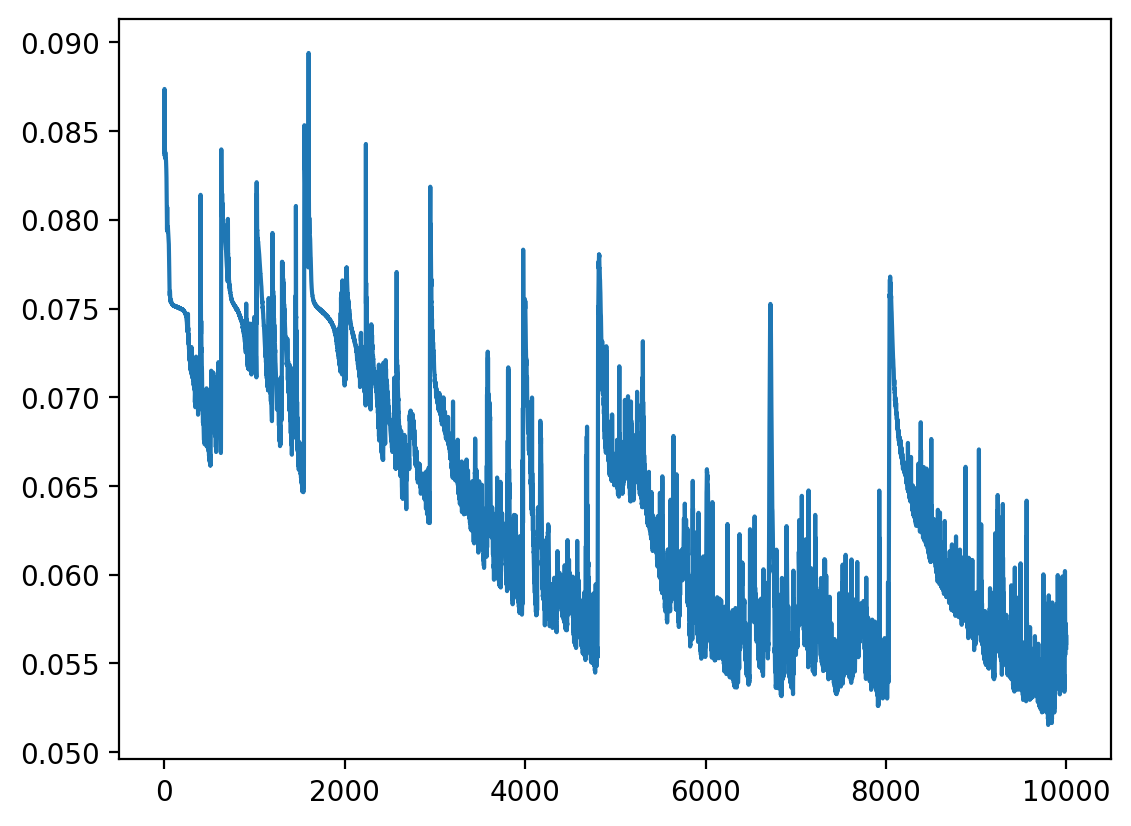

In [58]:
plt.plot(hist_loss)

In [46]:
eval_reconstruction(ae, test_loader, verbose=False)

0.27355849742889404

In [56]:

with torch.no_grad():
    error = 0
    for batch_idx, (x, _) in enumerate(test_loader):
        recon_x = ae(x)
        error += nn.MSELoss(reduction="sum")(target=x, input=recon_x)

    n = len(test_loader.dataset)
    error /=  n*ae.time_horizon

print(f"Avg reconstruction error: {error.item():.4f}")

Avg reconstruction error: 0.0526
